
# SWAHILI AUDIO PREDICTION: AN AUTOMATIC SPEECH RECOGNITION (ASR) PREDICTIVE MODELING PROJECT

### Group 4 Members

**Manyara Baraka**

**Nangi Mugira**

**Collins Kanyiri**

**Faith Nyawira**

**Benson Kinyua**

**Jacinta Mukii**


## 1. BUSINESS UNDERSTANDING

### 1.1. Problem Statement
Swahili, also known as Kiswahili, has a rich history that spans centuries and is now one of the most widely spoken languages in Africa, with millions of speakers across various countries. Today, Swahili is not only a language of communication but also a symbol of cultural heritage and identity for millions of people in East Africa and beyond. Its history reflects the dynamic nature of language, shaped by trade, migration, colonization, and cultural exchange over the centuries.

With the increasing availability of digital audio content in Swahili, AnalytiX Insights aims to 
develop automated systems that can classify and categorize Swahili audio recordings for various applications, including speech recognition, content recommendation, and language learning tools. 

### 1.2 Objectives
#### 1.2.1 Main Objective
The objective of this data science project is to build a machine learning model capable of classifying Swahili audio recordings into predefined categories or labels. This model will enable the automated categorization of Swahili audio content, making it easier to organize, search, and retrieve relevant audio resources.

#### 1.2.2 Specific Objectives
 - To develop a machine learning model capable of classifying Swahili audio recordings.
 - Create a scalable and efficient system for real-time or batch audio classification.
 - To provide recommendations for further enhancements and applications.


### 1.3 Key Challenges

- Data Collection: Acquiring a diverse and representative dataset of Swahili audio recordings spanning different categories and accents.
- Feature Extraction: Identifying relevant audio features or representations that capture the essence of Swahili speech.
- Model Generalization: Building a model that can generalize well across various accents, dialects, and speaking styles within Swahili.
- Real-time Processing: Designing the system for real-time or near-real-time audio classification, depending on the application.

### 1.4 Scope

This project will focus on the development of a machine learning model for Swahili audio classification. It will involve data collection, preprocessing, feature extraction, model training, and evaluation. The model will be designed to classify audio recordings into respective English words.


## 2. IMPORTING LIBRARIES

In [18]:
# Basic data manipultation and analysis
import numpy as np
import pandas as pd

# Data visualization libraries
from scipy.ndimage import minimum_filter1d
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Audio preprocessing 
import os
import torch
import shutil
import random
import librosa
import librosa.display
import noisereduce as nr
import IPython.display as ipd
from tqdm.notebook import tqdm

from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Machine learning models
import torchaudio
from torch import nn
from torchsummary import summary
from torchvision.models import resnet18, ResNet18_Weights

# model evaluation metrics
import sklearn.preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score
from jiwer import wer

# Import custom functions and trained models.
import Functions
import pickle

# To ensure a more organized and tidy output.
import warnings
warnings.filterwarnings('ignore')



In [9]:
# Set seed
np.random.seed(2022)

## 2. DATA COLLECTION

**Loading Data**

In [11]:
# Load files
train = pd.read_csv('Data/Train.csv')
test = pd.read_csv('Data/Test.csv')

# Unzip audio zip file
shutil.unpack_archive('Data/Swahili_words.zip', 'Swahili_words')

In [12]:
# Preview train set
train.head()

Word_id Swahili_word English_translation
0  id_v8rz06e6rv31.wav        mbili                 two
1  id_vmbwicdpfn68.wav         tatu               three
2  id_injlouhxg1hg.wav         ndio                 yes
3  id_gdq23p6xgzya.wav          nne                four
4  id_lpstklz51zpz.wav         nane               eight

The dataset has three columbs:
- **Word_id:** Has all the audio files.
- **Swahili_word:** The trasncription of the Audio file.
- **English Translation:** The respective translation of the Swahili word.

In [13]:
# Preview test set
display(test.head(), train.shape, test.shape)

Word_id
0  id_jp2pxl0r84ya.wav
1  id_ndduqqvthbpx.wav
2  id_36oxymxfcm6q.wav
3  id_ue9b0to760pg.wav
4  id_prja4oprb914.wav

(4200, 3)

(1800, 1)

In [14]:
# Target distribution
train.Swahili_word.value_counts()

Swahili_word
mbili     350
tatu      350
ndio      350
nne       350
nane      350
hapana    350
sita      350
tisa      350
moja      350
saba      350
tano      350
kumi      350
Name: count, dtype: int64

- We only have 12 Swahili words to work with which are equaly distributed across the dataset.
- We will sample random audio files from the dataset to determine whether the Swahili transcription are right according to the transcription.

In [15]:
# Sample some words
for word in random.sample(train.Swahili_word.unique().tolist(), 6):
  sample = train[train.Swahili_word == word].Word_id.sample(1).values[0]
  display(word, sample, ipd.Audio('Swahili_words/'+ sample ))

'tano'

'id_h3bzrmh0w9ws.wav'

'saba'

'id_0lurju3a5cuo.wav'

'sita'

'id_pdh3vah5z5iy.wav'

'hapana'

'id_k0jhodnxx8up.wav'

'tisa'

'id_wcse2kt25c3r.wav'

'moja'

'id_ni9z4dj1rkch.wav'

- The Audio files are correct, all recorded with different voices under different circumstances that is with background noises, high pitch, low pitch, high frequencies and other surroindings. Will need to do data cleaning for better model training and building

## 3. DATA CLEANING

1. **Load Audio Files:** It can load multiple audio files from a specified folder, allowing you to work with a collection of audio recordings.

2. **Visualize Audio Waveforms:** It visualizes the waveform of each loaded audio file using Matplotlib, which helps you inspect the raw audio data.

3. **Resample Audio:** It resamples the audio to a specified target sampling rate if the native sampling rate of the audio files differs from the target rate. This can be important when you need audio data to be at a consistent sampling rate.

4. **Optional Noise Reduction:** Although this code includes a placeholder for noise reduction using the `noisereduce` library, you can replace it with your own noise reduction techniques if needed. Noise reduction is particularly useful when dealing with audio recordings that contain background noise.

5. **Normalization:** It normalizes the audio data to ensure that it falls within a common range, typically between -1 and 1. Normalization can help make the audio data more suitable for analysis or modeling.

6. **Error Handling:** The code includes error handling to handle exceptions that may occur during audio processing, ensuring that the script doesn't crash if there are issues with specific audio files.

Found 6000 files


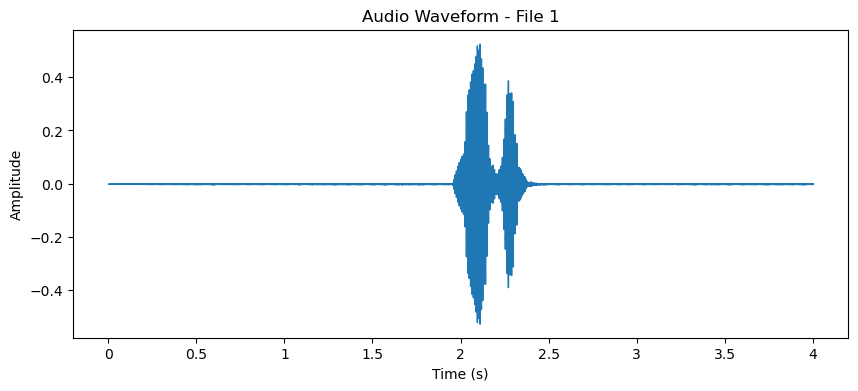

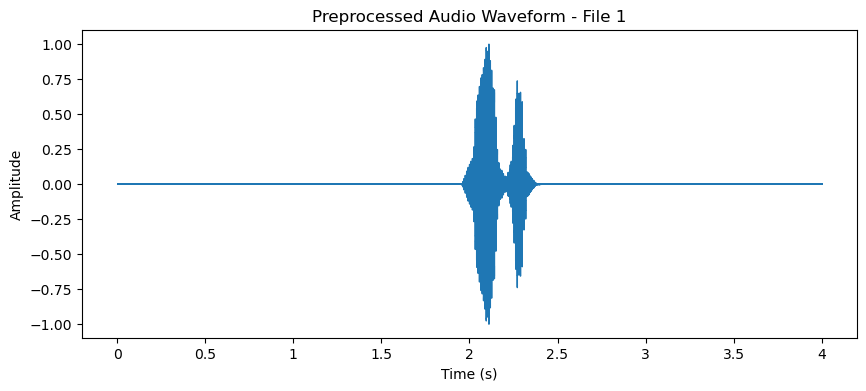

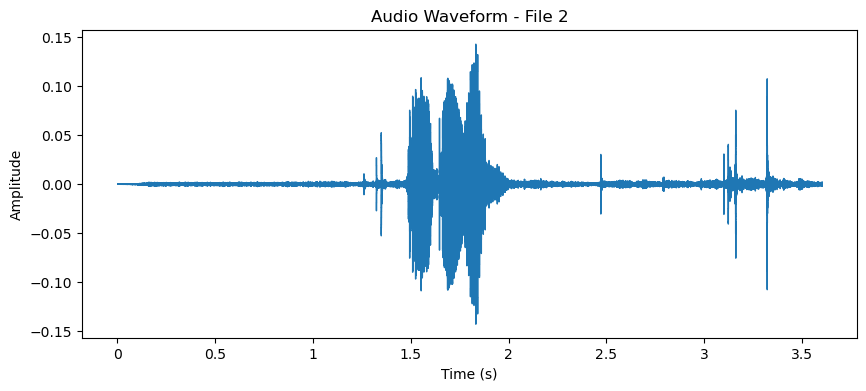

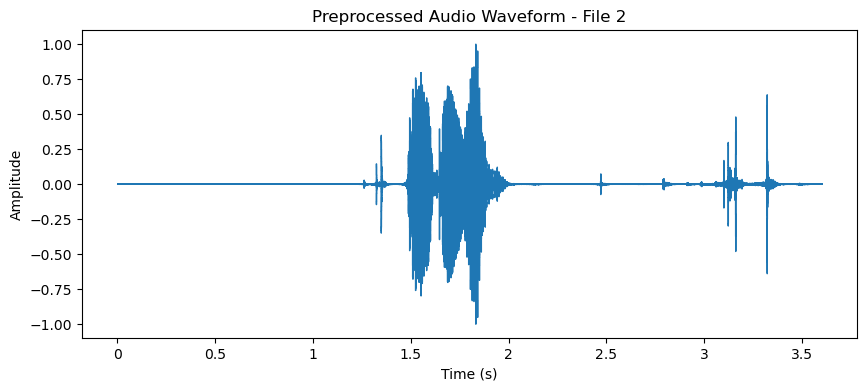

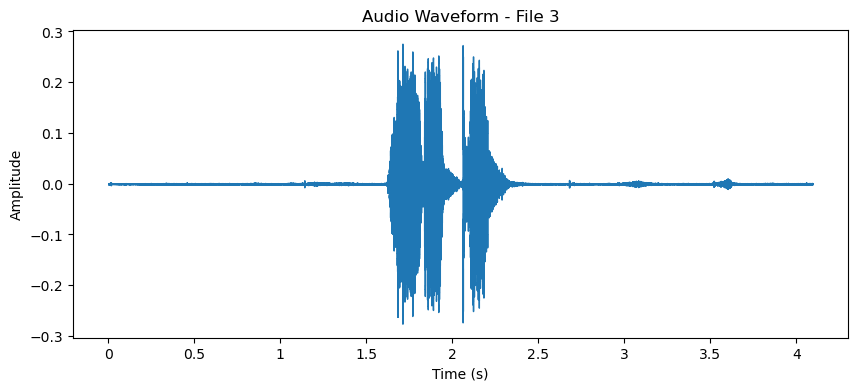

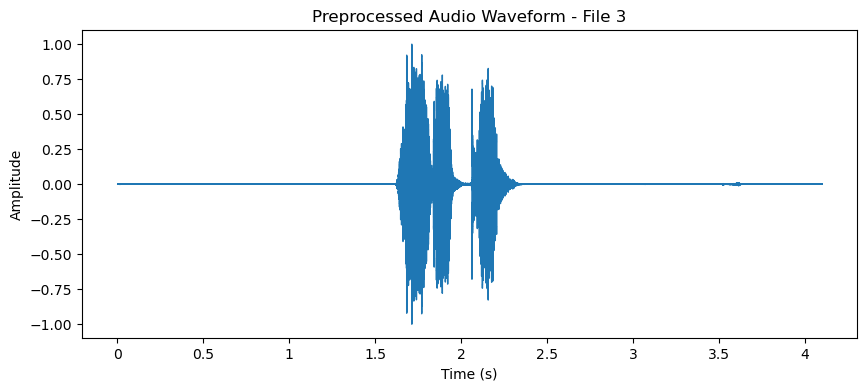

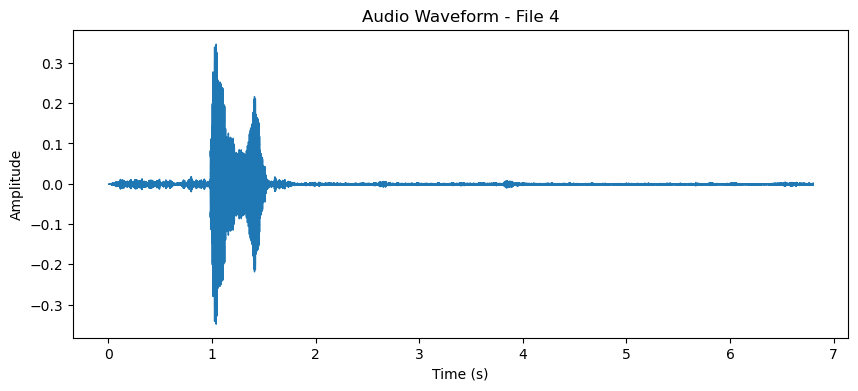

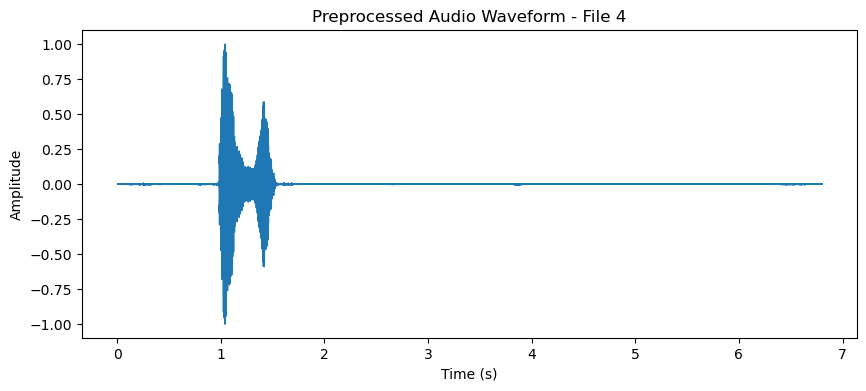

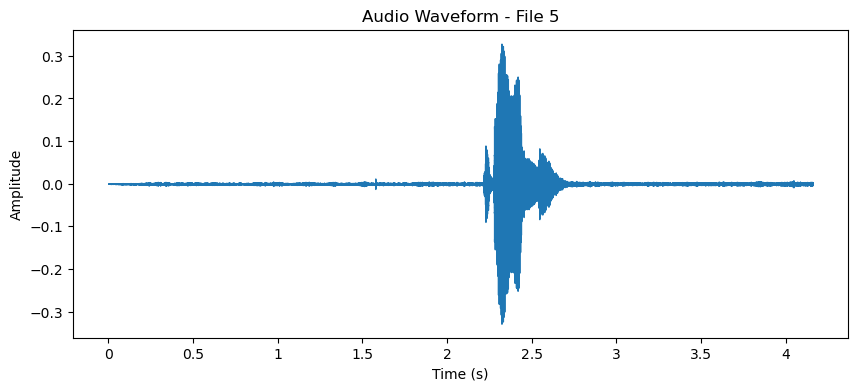

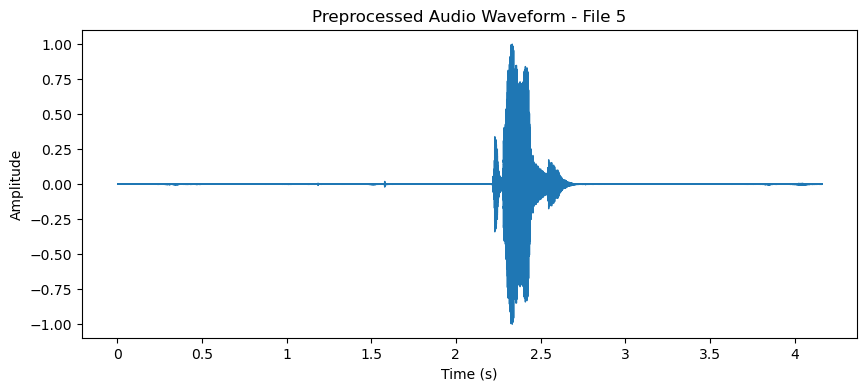

In [17]:
# Load the dummy audio files
data_folder = r'Swahili_words'
audio_files = [os.path.join(data_folder, filename) for filename in os.listdir(data_folder)]  # get list of audio files
audio_files = [audio_file for audio_file in audio_files if audio_file.endswith('.wav')]  # filter out non-audio files
print(f'Found {len(audio_files)} files')  # print the number of files

# Limit the number of visualizations to 5
num_visualizations = 5
for i, audio_file in enumerate(audio_files[:num_visualizations]):
    try:
        y, sr = librosa.load(audio_file, sr=None)  # Load the audio file with its native sampling rate

        # Visualize the audio waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Audio Waveform - File {i + 1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

        # Preprocessing steps
        target_sr = 16000  # Target sampling rate (e.g., 16 kHz)
        if sr != target_sr:
            y = librosa.resample(y, sr, target_sr)
            sr = target_sr

        # 2. Noise reduction (optional):
        # You can apply noise reduction techniques if the audio has background noise.
        y= nr.reduce_noise(y, sr=sr)

        # 3. Normalization:
        # Normalize the audio to a common range, usually between -1 and 1.
        y = librosa.util.normalize(y)

        # 4. Plot the preprocessed audio waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Preprocessed Audio Waveform - File {i + 1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

    except Exception as e:
        print(f"Error processing file: {audio_file}")
        print(e)

- Our audio files are clean, we can observe the difference of the original file and the cleaned file. The function removed unnnecessary noises.

## 4. EXPLORATION DATA ANALYSIS

Create a function to define whether each of the words have different audio files and how they appear. Will randomly select the Swahili word and display its wave-form as spoken and shown in with the different audio files

In [ ]:
# Create a dictionary to check the audio files with the same transcription 
# Get three sample
dict_samples=dict()
for word in train['Swahili_word'].unique().tolist():
    sample = train[train['Swahili_word'] == word]['Word_id'].sample(3).values[:]
    dict_samples[word] = sample

In [ ]:
dict_samples

{'mbili': array(['id_5rlc5o5n1s1b.wav', 'id_htx9vb45vk8h.wav',
        'id_cjhhxujadkd1.wav'], dtype=object),
 'tatu': array(['id_5aly5y4f0ihq.wav', 'id_gdhnpb9tk6ju.wav',
        'id_02yh4h2au53z.wav'], dtype=object),
 'ndio': array(['id_uy4dyk2y8itg.wav', 'id_1uh1rjrqhoxs.wav',
        'id_q8ublattuf6h.wav'], dtype=object),
 'nne': array(['id_nmwysb9aih92.wav', 'id_1pca3ef7fyf6.wav',
        'id_z4bsgktw3vgy.wav'], dtype=object),
 'nane': array(['id_31s05g5prv7n.wav', 'id_no8u2tvobi1m.wav',
        'id_6onfy14u6ztv.wav'], dtype=object),
 'hapana': array(['id_j4u9jxt3qows.wav', 'id_69xkivr12erg.wav',
        'id_2e06s8yxz1m4.wav'], dtype=object),
 'sita': array(['id_uegn3hwrd2eo.wav', 'id_0r7awrawc36d.wav',
        'id_t4xbvwqx3qdu.wav'], dtype=object),
 'tisa': array(['id_kbykqygrrlc1.wav', 'id_g7gt7q60x9fx.wav',
        'id_bo3voxkx4890.wav'], dtype=object),
 'moja': array(['id_syxtdgknf2me.wav', 'id_tsumlqgjrphf.wav',
        'id_m9784h87c2ce.wav'], dtype=object),
 'saba': array(['

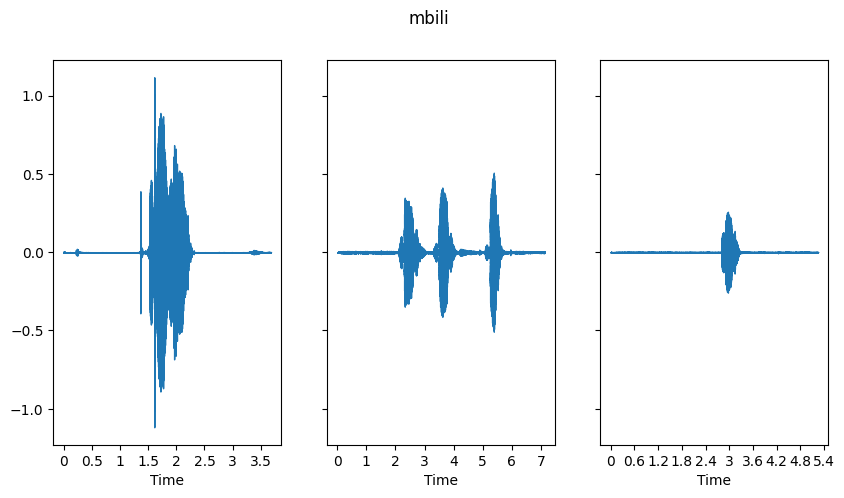

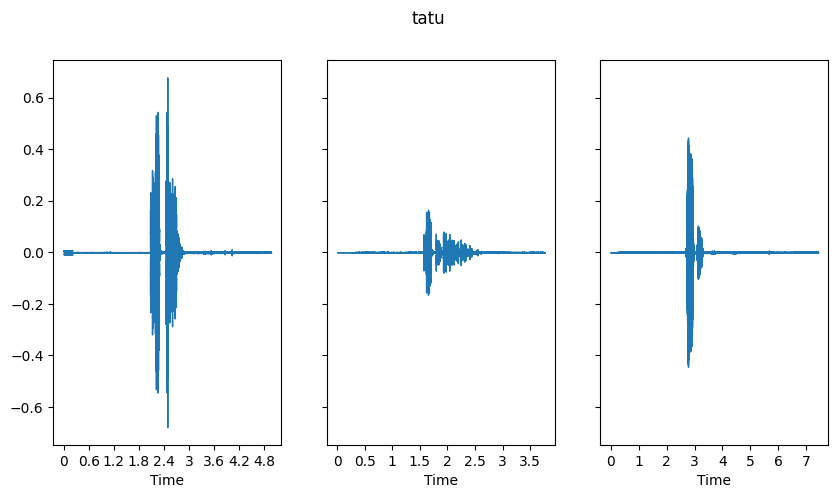

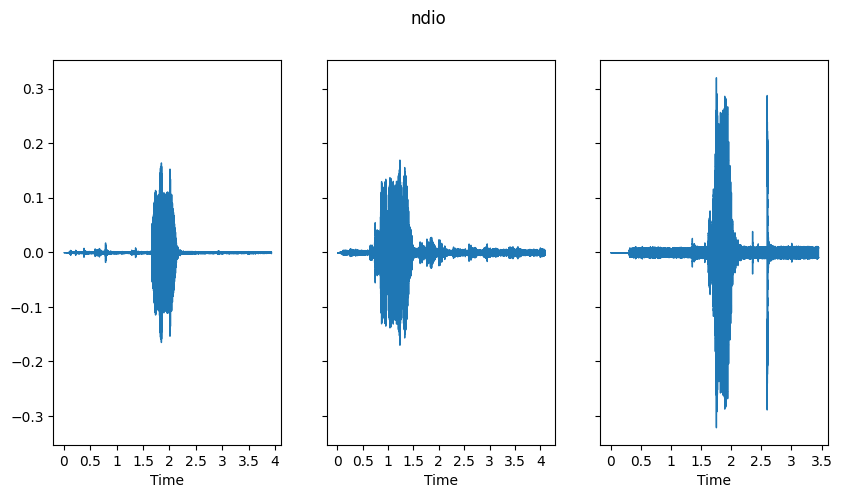

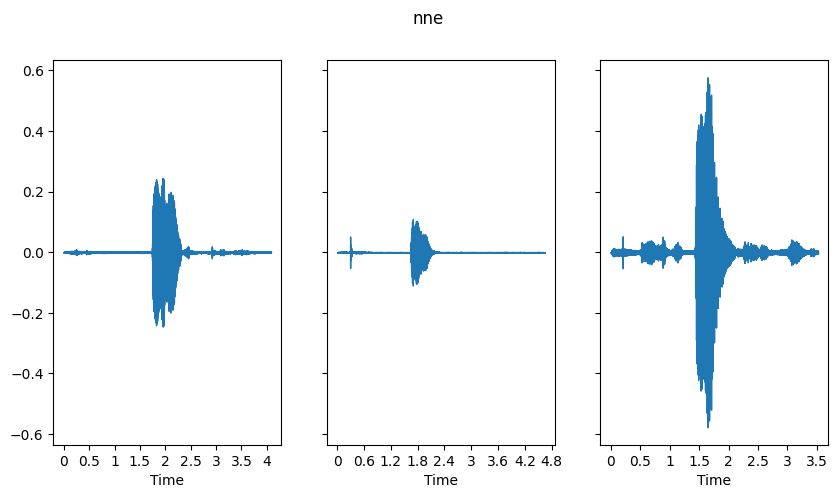

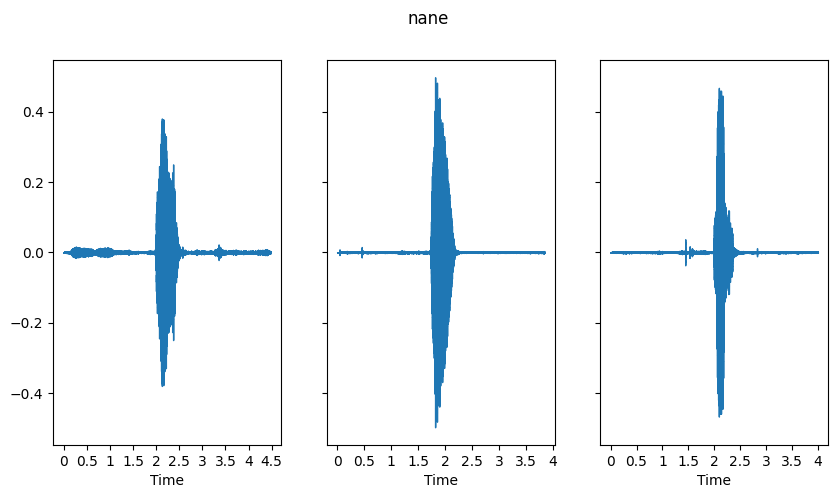

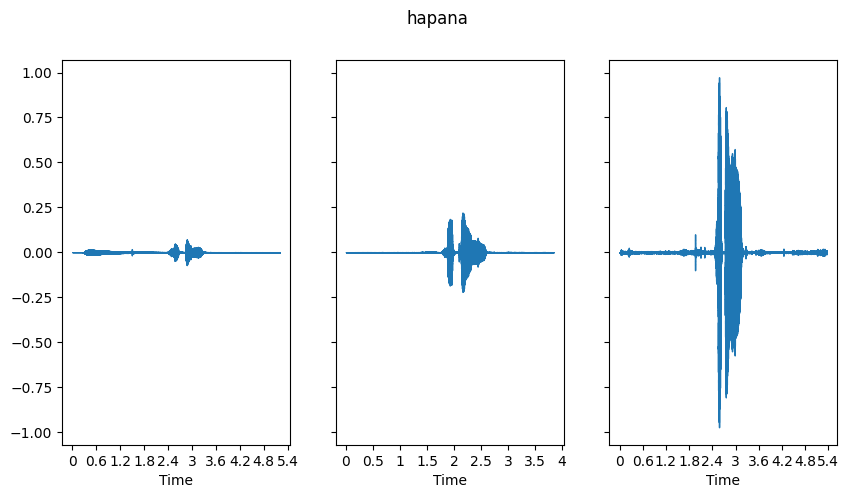

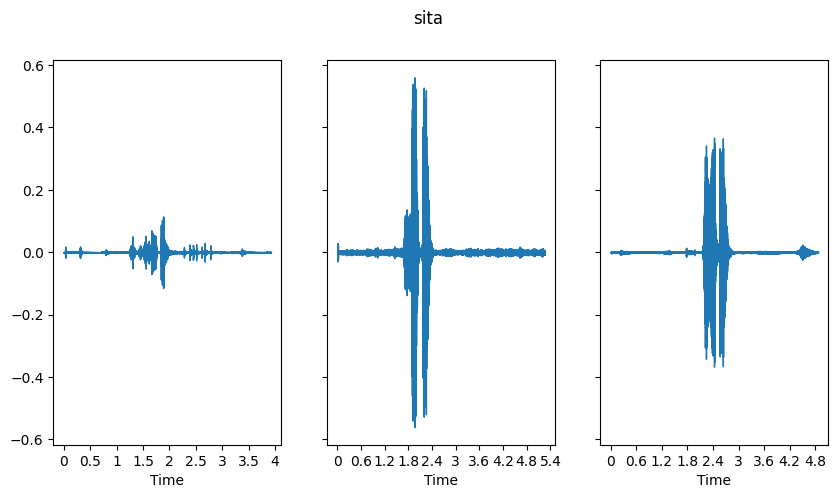

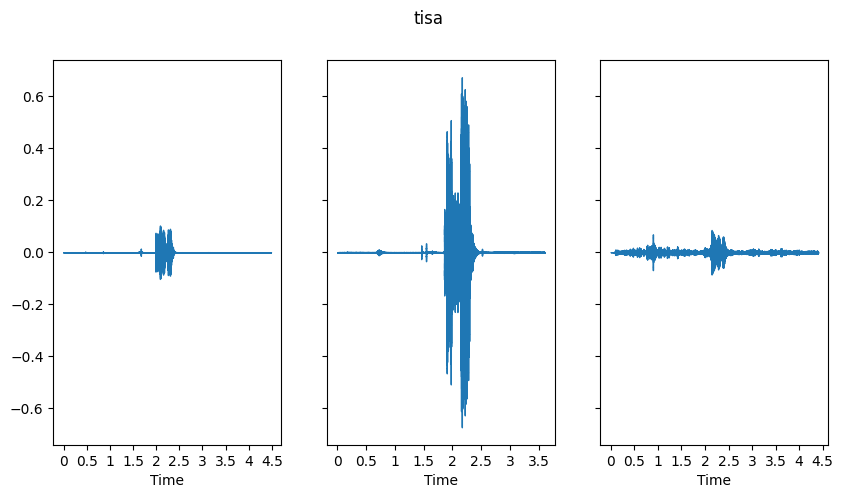

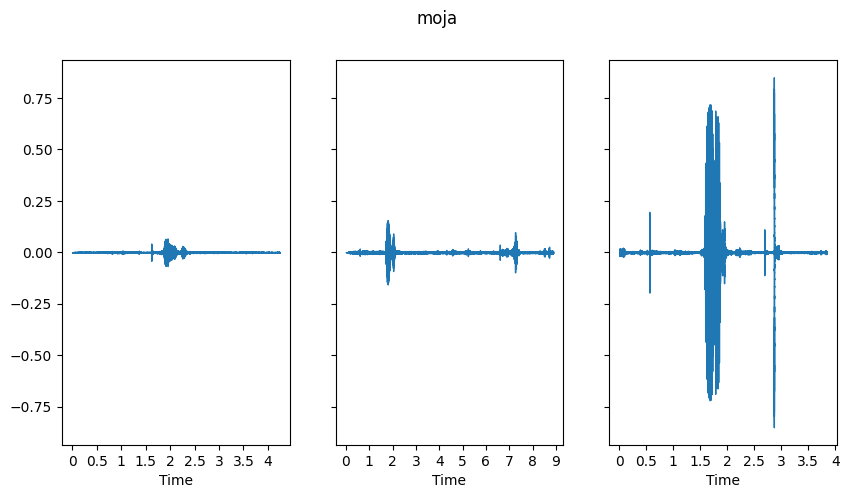

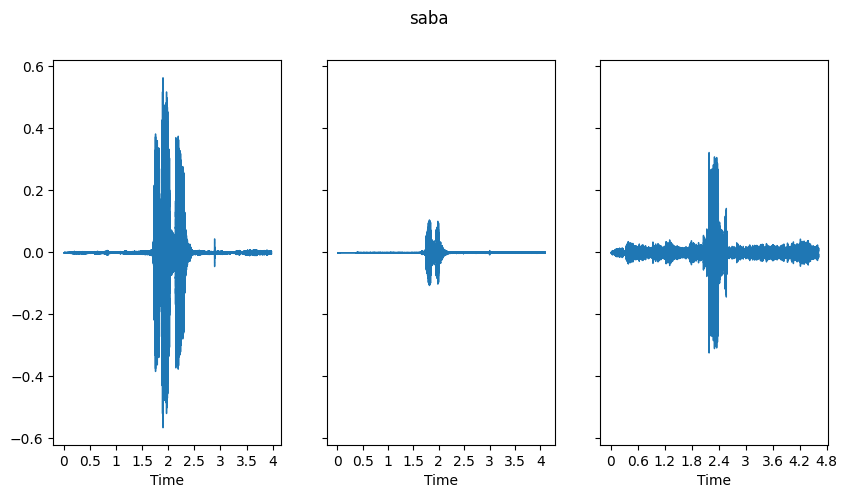

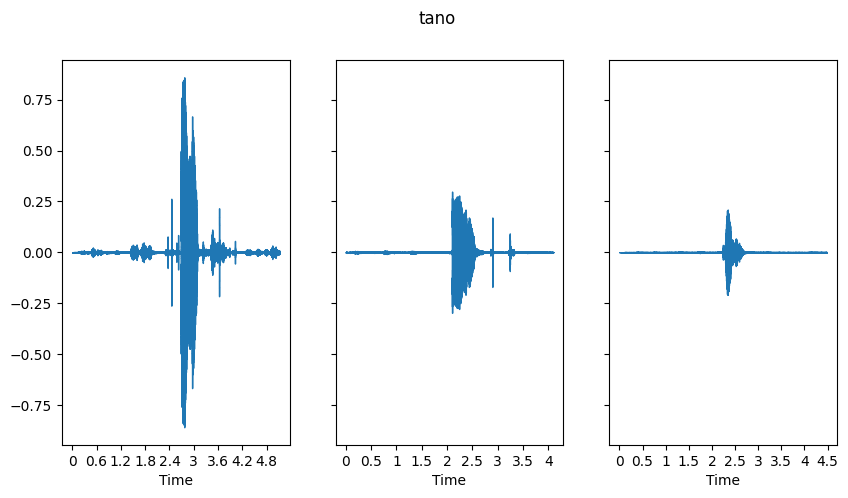

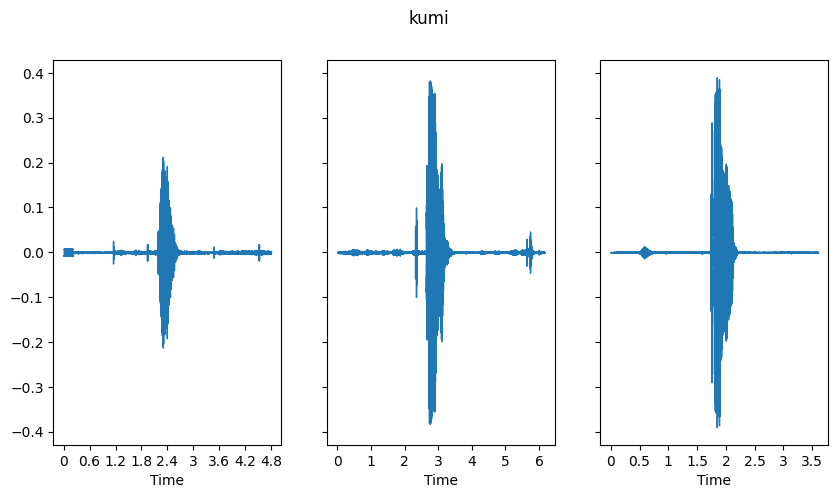

In [ ]:
# show three wavefiles for all words in time domain, for easy comparison between the words
for word in dict_samples:
    i=0
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
    fig.set_size_inches(10, 5)
    fig.suptitle(word)
    for audiofile in dict_samples[word]:
        x, sr = librosa.load('Swahili_words/'+audiofile)
        img = librosa.display.waveshow(x, sr=sr, ax=ax[i])
        i+=1

**Observation**
- Each word has its own unique display of the wave-form. 
- Regardless of the same word haveing different amplitudes there is a consistency in the wave forms, where there is a higher amplitued it appears almost on all the wave forms of the same word.

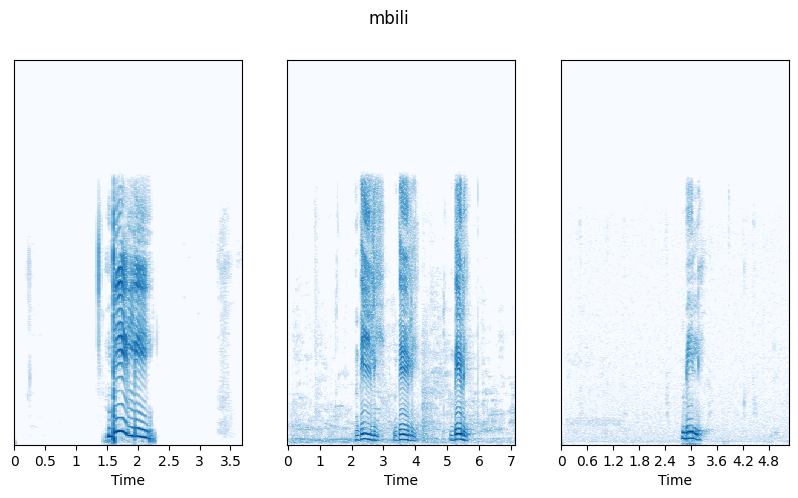

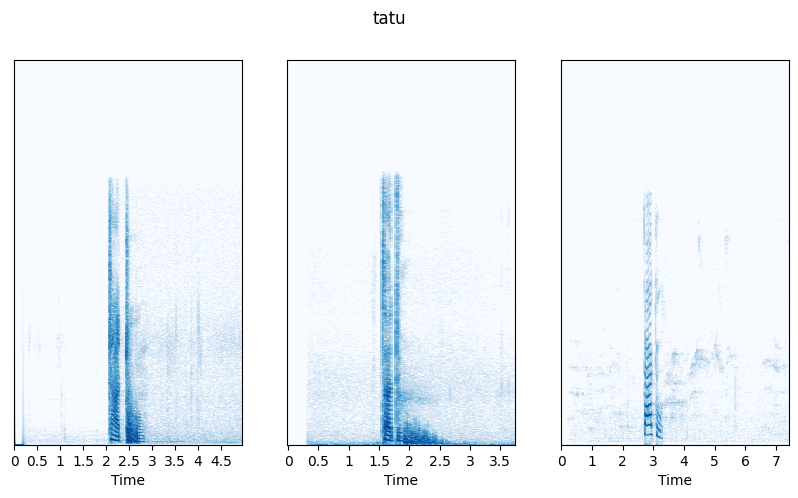

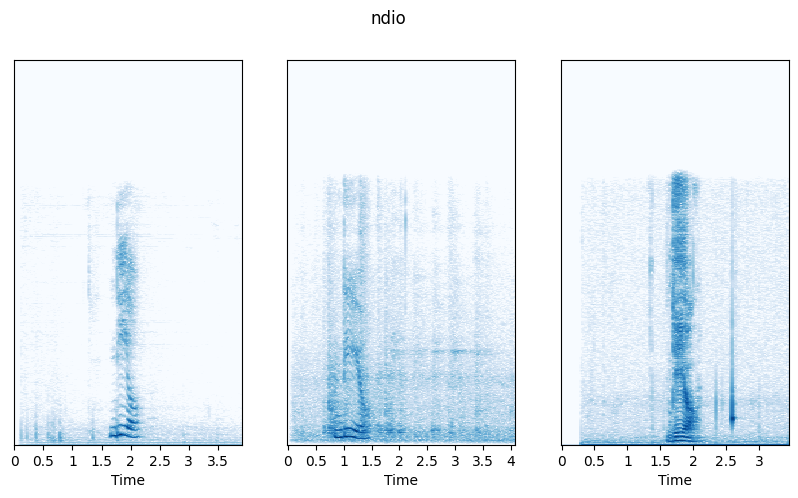

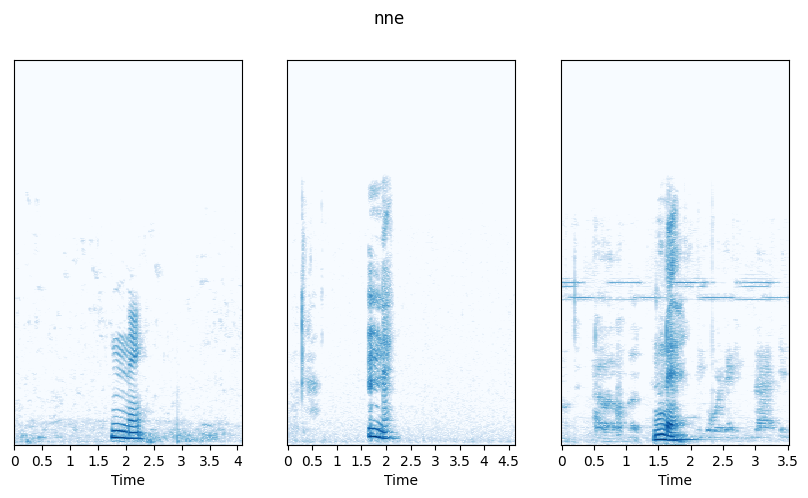

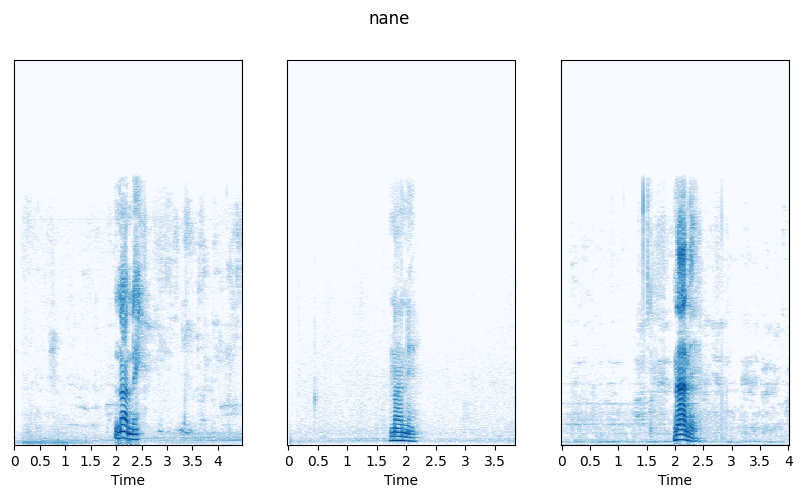

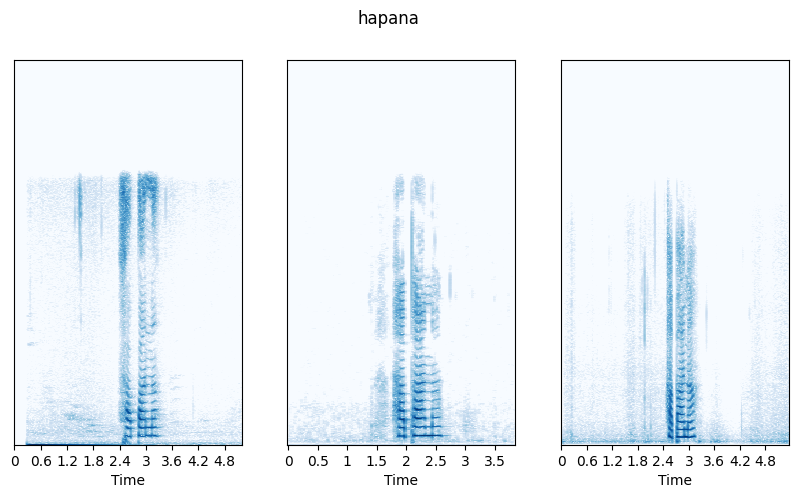

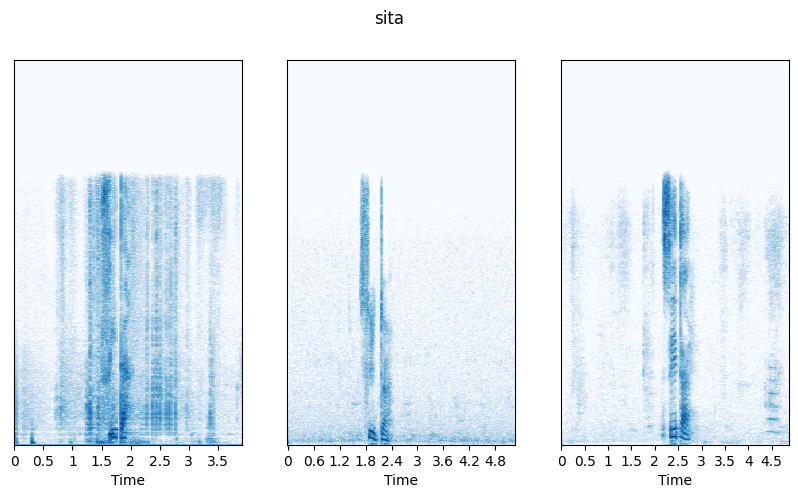

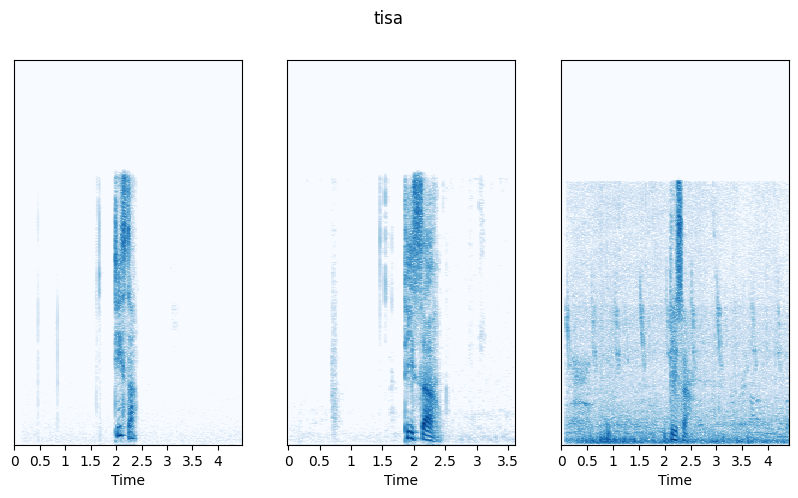

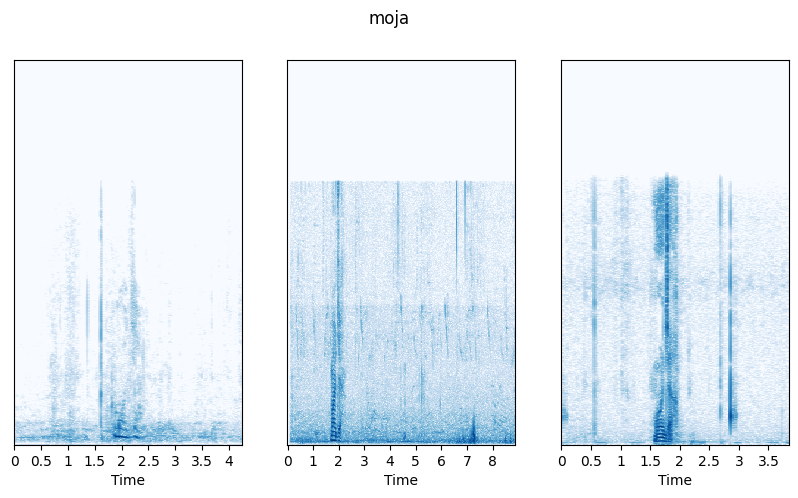

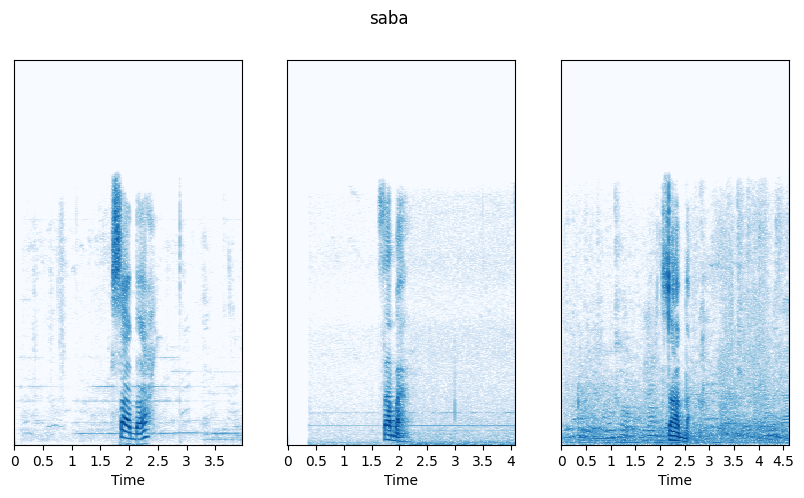

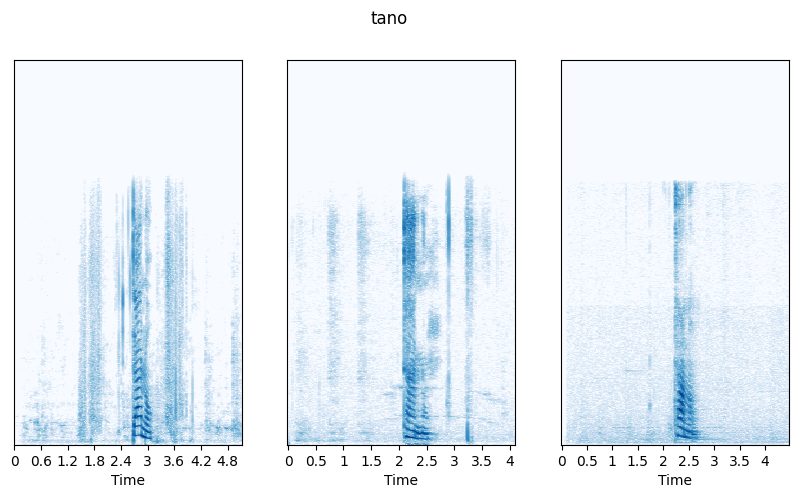

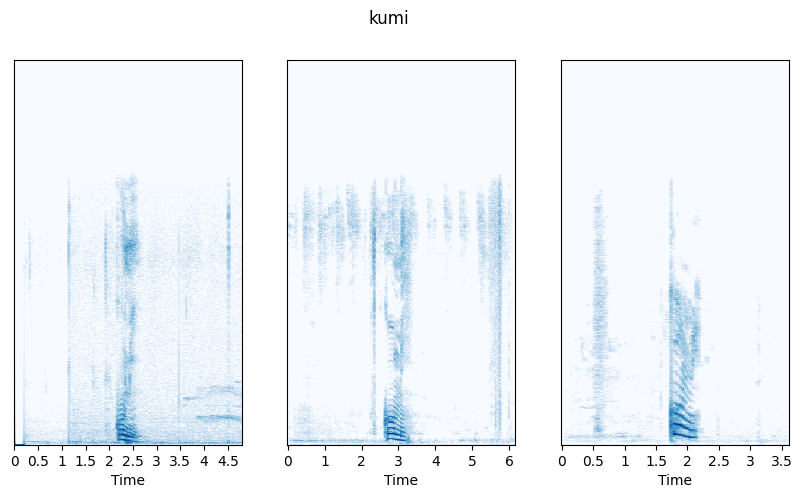

In [ ]:
# Converting the wave-forms to spectograms
for word in dict_samples:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
    fig.set_size_inches(10, 5)
    fig.suptitle(word)
    for audiofile in dict_samples[word]:
        x, sr = librosa.load('Swahili_words/' + audiofile)
        X = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
        ax[i].set_facecolor('white')  # Set the background color to white
        img = librosa.display.specshow(X, x_axis='time', sr=sr, ax=ax[i], cmap='Blues')  # Set the colormap to 'Blues'
        #ax[i].set_title(f'Subplot {i + 1}')  # Add a title to the subplot
        i += 1

plt.show()  # This will display the plot


## 4. Feature Engineering
There are many ways to tackle this challenge. In this project we will use Spectograms.
- Spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.  Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time.

- Will do deep learning on the audio, generate a spectrogram and treat this as an image classification task, use some signal processing tricks to look for close matches, try to extract meaningful features such as dominant frequencies.



### 1. Spectograms

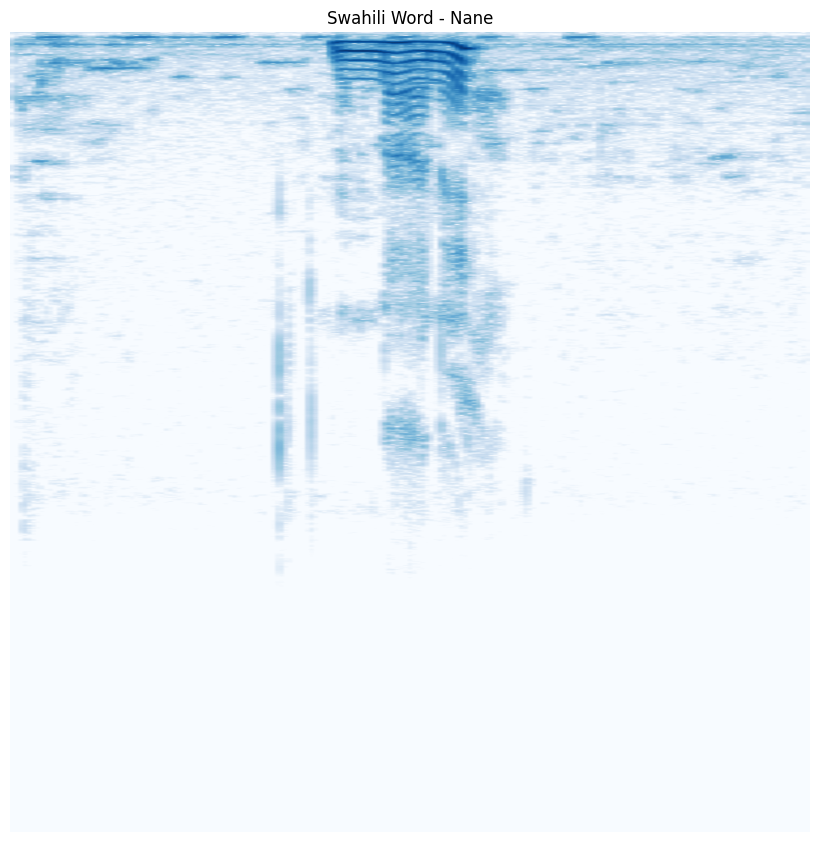

In [ ]:
# Going from a sound to an image: spectrograms
os.mkdir('spectrograms') # Create a folder to store the spectrograms

# Function to generate spectrogram
def gen_spectrogram(path):
    x, sr = librosa.load(path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X)[:,:min(1025, len(X[0]))])

    fig = plt.figure(frameon=False)
    fig.set_size_inches(8, 8)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.set_facecolor('white')  # Set the background color to white
    
    fig.add_axes(ax)

    plt.title('Swahili Word - Nane')

    ax.imshow(Xdb, aspect='auto', cmap='Blues')  # Set the colormap to 'Blues'

    spec_path = 'spectrograms/' + path.split('/')[1][:-4] + '.png'
    fig.savefig(spec_path, dpi=512//8)

gen_spectrogram('Swahili_words/id_pwvzavl2dl6q.wav')
display(ipd.Audio('Swahili_words/id_pwvzavl2dl6q.wav'))

Will create a spectogram for each audio file in our dataset.

In [ ]:
# Concatenate train with test for easy data manipulation
train_test_files = train.Word_id.tolist() + test.Word_id.tolist()

for word_id in tqdm(train_test_files):
  # Check if we've already generated a spectrogram, and if not, make one
  spec_path = 'spectrograms/' + word_id[:-4] +'.png'
  if not os.path.isfile(spec_path):
    plt.clf()
    gen_spectrogram('Swahili_words/'+ word_id)
  ipd.clear_output(wait=True)
  plt.close()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Checking that the spectrograms were generated successfully:
len(os.listdir('Swahili_words')) == len(os.listdir('spectrograms')), len(os.listdir('spectrograms'))

(True, 6000)

In [ ]:
# Add spectrogram path to train set
train['spec_name'] = [x.split('.')[0] + '.png' for x in train.Word_id]

# Preview train
train.head()

Word_id Swahili_word English_translation            spec_name
0  id_v8rz06e6rv31.wav        mbili                 two  id_v8rz06e6rv31.png
1  id_vmbwicdpfn68.wav         tatu               three  id_vmbwicdpfn68.png
2  id_injlouhxg1hg.wav         ndio                 yes  id_injlouhxg1hg.png
3  id_gdq23p6xgzya.wav          nne                four  id_gdq23p6xgzya.png
4  id_lpstklz51zpz.wav         nane               eight  id_lpstklz51zpz.png

### 2. MFCCs

This process involves extracting the Mel-Frequency Cepstral Coefficients (MFCCs) from the audio signal. We do this by using the `librosa.feature.mfcc()` function.

The advantage of MFCCs is that they capture the underlying structure of the audio signal, making them useful for speech recognition tasks.

The advantage of using MFCCs is that they can be used as inputs for a speech recognition model.

Delta and Delta-Delta MFCCs can be extracted from the MFCCs using the `librosa.feature.delta()` function. This function calculates the difference between the current and previous MFCC coefficients. The advantage of using Delta and Delta-Delta MFCCs is that they can be used as inputs for a speech recognition model.

MFCCs shape: (20, 187)


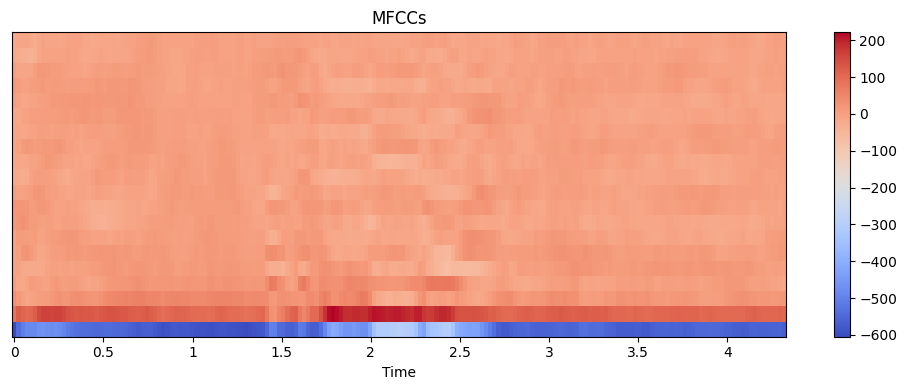

In [ ]:
# Create a folder to store the MFCC plots
if not os.path.exists('mfccs_plots'):
    os.mkdir('mfccs_plots')

def compute_and_display_mfccs(audio_path):
    """
    Compute MFCCs from an audio file and display them as a plot.

    Parameters:
        audio_path (str): Path to the audio file.
    """
    # Load the audio file
    x, sr = librosa.load(audio_path)

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=x, sr=sr)

    # Print the shape of MFCCs
    print(f"MFCCs shape: {mfccs.shape}")

    # Display MFCCs as a plot
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.tight_layout()

    # Save the MFCC plot as an image
    plot_path = os.path.join('mfccs_plots', os.path.basename(audio_path)[:-4] + '_mfccs.png')
    plt.savefig(plot_path, dpi=300)
    plt.show()

# Example usage:
audio_file_path = 'Swahili_words/id_pwvzavl2dl6q.wav'
compute_and_display_mfccs(audio_file_path)

In [ ]:
for word_id in tqdm(train_test_files):
    
    # Check if we've already generated MFCCs, and if not, make them
    mff_path = 'mfccs/' + word_id[:-4] + '.png'
    if not os.path.isfile(mff_path):
        plt.clf()
        compute_and_display_mfccs('Swahili_words/' + word_id)
    ipd.clear_output(wait=True)
    plt.close()


MFCCs shape: (20, 190)


<Figure size 640x480 with 0 Axes>

In [ ]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound

spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
spectral_centroids.shape

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r');

In [ ]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)

#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time');

## 3